In [1]:
import numpy as np
import math
from scipy.stats import chi2
import matplotlib.pyplot as plt
from scipy.stats import uniform
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ksone
from scipy.stats import norm
from scipy.stats import chisquare
from scipy.stats import expon
from scipy.stats import multivariate_normal
from scipy.stats import pareto
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def GenerateStateTime(w_1,w_2,States):
    if type(States) != list:
        if States==1:
            StateTimes = -np.log(np.random.random())/w_1
        else:
            StateTimes = -np.log(np.random.random())/w_2
    return StateTimes

In [3]:
def GenerateServiceTime(servicemean,N):
    return -np.log(np.random.rand(N))*servicemean

In [4]:
def GenerateArrivalTime(lmbda,N):
    return -np.log(np.random.rand(N))/lmbda

In [115]:
def DepositToQueue(arrtime,Q,Ql):
    #arrtime is the arrival time
    #Q is current queue
    #Ql is the queue lengths with corresponding time
    Q.append(arrtime)
    if Q:
        Ql.append([arrtime,len(Q)])
    else:
        Ql.append([arrtime,0])

In [6]:
def DrawFromQueue(T,Q,Ql,Qt,S):
    #T is current time
    #Q is current queue
    #Qt is total queue waiting times
    #S is server status
    #Ql is the queue lengths with corresponding time
    Qt.append(T-Q[0])
    Q.pop(0)
    if Q:
        Ql.append([T,len(Q)])
    else:
        Ql.append([T,0])
    S = 1
    return S

In [184]:
def DepositToQueueWithTime(arrtime,Q,Ql,w):
    import numpy as np
    #arrtime is the arrival time
    #Q is current queue
    #Ql is the queue lengths with corresponding time
    #w is the waiting time mean
    Q.append([arrtime,arrtime-np.log(np.random.random())*w])
    if Q:
        Ql.append([arrtime,len(Q)])
    else:
        Ql.append([arrtime,0])

In [191]:
def DrawFromQueueWithTime(T,Q,Ql,Qt):
    #T is current time
    #Q is current queue
    #Qt is total queue waiting times
    #Ql is the queue lengths with corresponding time
    #Ts is the checking time for queue object
    Qt.append(T-Q[0][0])
    Ts = Q[0][1]
    Q.pop(0)
    if Q:
        Ql.append([T,len(Q)])
    else:
        Ql.append([T,0])
    return Ts

In [48]:
def SimQueuePP(N,servicemean,w_1,w_2,lmbda,K,L):
    import heapq
    import numpy as np
    #N is the number of units
    #s is the service time mean
    #w_1 is the frequency to switching from ON to OFF
    #w_2 is the frequency to switching from OFF to ON
    #lmbda is the arrival intensity
    #L is the superpositions
    
    
    #Q is the current queue
    Q = []
    #Qt is the saved queue times
    Qt = []
    #Ql is the queue lengths with corresponding time
    Ql = []
    #M is the queued amount
    M = 0
    #S is the server status
    S = np.zeros((N,))
    #States is the state of the l'th IPP
    States = np.ones((L,))
    #T is the current event time
    T = 0
    #events is the prioritized event queue
    events = []
    #Here we generate the first arrivals and state change events and push events to event queue
    arrival = GenerateArrivalTime(lmbda,L)
    for l in range(L):
        heapq.heappush(events,(GenerateStateTime(w_1,w_2,1),('StateChange',l)))
    for indx,e in enumerate(arrival):
        heapq.heappush(events,(e,('Arrival',indx,e)))
    #k is the number of customers processed
    k = 0
    #A is the l'th arrival state, if 0 no arrival is present, if 1 an arrival is present
    As = np.ones((L,))
    #At is the arrival times for the arrival time distribution
    At = []
    while(k<K):
        #Prints for debugging
        #print(list(events))
        #print(Ql)
        
        #Extract next event
        event = heapq.heappop(events)
        #Set new event time
        T = event[0]
        #Check for event type
        if event[1][0]=='StateChange':
            pass
        elif event[1][0]=='Arrival':
            indx = event[1][1]
            #Set no active arrival for the IPP
            As[indx] = 0
            #Check state
            if States[indx]==0:
                #Do not arrive if state is OFF
                continue
            else:
                #Save arrival time
                At.append(event[1][2])
                #Generate new arrival time
                arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                #Check server availability
                if np.any(S==0):
                    #Save to closest availble server
                    serverindx = np.argmax(S==0)
                    S[serverindx] = 1
                    #Generate service time
                    servicetime = GenerateServiceTime(servicemean,1)[0]
                    #Push events to event queue
                    heapq.heappush(events,(servicetime+T,('Service',serverindx)))
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                else:
                    #Deposit to queue
                    DepositToQueue(T,Q,Ql)
                    #Push events to event queue
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                    #Increase customers been in queue
                    M += 1
        elif event[1][0]=='Service':
            indx = event[1][1]
            #Set server to idle
            S[indx] = 0
            #Increase customers served
            k+=1
            #Check if queue is empty
            if Q:
                #Draw from queue
                S[indx] = DrawFromQueue(T,Q,Ql,Qt,S[indx])
                #Generate and push new service times
                servicetime = GenerateServiceTime(servicemean,1)[0]
                heapq.heappush(events,(servicetime+T,('Service',indx)))
            else:
                continue
    M -= len(Q)
    #Ql is the queue lengths with corresponding time            
    #Qt is the saved queue times
    #M is the queued amount
    #At is the arrival times for the arrival time distribution
    return Ql,Qt,M,At

In [69]:
def SimQueueIPP(N,servicemean,w_1,w_2,lmbda,K,L):
    import heapq
    import numpy as np
    #N is the number of units
    #s is the service time mean
    #w_1 is the frequency to switching from ON to OFF
    #w_2 is the frequency to switching from OFF to ON
    #lmbda is the arrival intensity
    #L is the superpositions
    
    
    #Q is the current queue
    Q = []
    #Qt is the saved queue times
    Qt = []
    #Ql is the queue lengths with corresponding time
    Ql = []
    #M is the queued amount
    M = 0
    #S is the server status
    S = np.zeros((N,))
    #States is the state of the l'th IPP
    States = np.ones((L,))
    #T is the current event time
    T = 0
    #events is the prioritized event queue
    events = []
    #Here we generate the first arrivals and state change events and push events to event queue
    arrival = GenerateArrivalTime(lmbda,L)
    for l in range(L):
        heapq.heappush(events,(GenerateStateTime(w_1,w_2,1),('StateChange',l)))
    for indx,e in enumerate(arrival):
        heapq.heappush(events,(e,('Arrival',indx,e)))
    #k is the number of customers processed
    k = 0
    #A is the l'th arrival state, if 0 no arrival is present, if 1 an arrival is present
    As = np.ones((L,))
    #At is the arrival times for the arrival time distribution
    At = []
    #SAt is the server activity times
    SAt = []
    sat = np.min(arrival)
    while(k<K):
        #Prints for debugging
        #print(list(events))
        #print(Ql)
        
        #Extract next event
        event = heapq.heappop(events)
        #Set new event time
        T = event[0]
        #Check for event type
        if event[1][0]=='StateChange':
            indx = event[1][1]
            #Check state
            if States[indx]==0:
                #Change state
                States[indx] = 1
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
                #If no arrival for the IPP, generate new arrival and push to event queue
                if As[indx] == 0:
                    arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
            else:
                #Change state
                States[indx] = 0#Generate new state time
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
        elif event[1][0]=='Arrival':
            indx = event[1][1]
            #Set no active arrival for the IPP
            As[indx] = 0
            #Check state
            if States[indx]==0:
                #Do not arrive if state is OFF
                continue
            else:
                #Save arrival time
                At.append(event[1][2])
                #Generate new arrival time
                arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                #Check server availability
                if np.any(S==0):
                    #Save to closest availble server
                    serverindx = np.argmax(S==0)
                    S[serverindx] = 1
                    #Generate service time
                    servicetime = GenerateServiceTime(servicemean,1)[0]
                    #Push events to event queue
                    heapq.heappush(events,(servicetime+T,('Service',serverindx)))
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                else:
                    #Deposit to queue
                    DepositToQueue(T,Q,Ql)
                    #Push events to event queue
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                    #Increase customers been in queue
                    M += 1
        elif event[1][0]=='Service':
            indx = event[1][1]
            #Set server to idle
            S[indx] = 0
            #Increase customers served
            k+=1
            #Check if queue is empty
            if Q:
                #Draw from queue
                S[indx] = DrawFromQueue(T,Q,Ql,Qt,S[indx])
                #Generate and push new service times
                servicetime = GenerateServiceTime(servicemean,1)[0]
                heapq.heappush(events,(servicetime+T,('Service',indx)))
            else:
                SAt.append(T-sat)
                sat = T
                continue
    M -= len(Q)
    #Ql is the queue lengths with corresponding time            
    #Qt is the saved queue times
    #M is the queued amount
    #At is the arrival times for the arrival time distribution
    return Ql,Qt,M,At,SAt

In [123]:
def SimQueueIPPLimit(N,servicemean,w_1,w_2,lmbda,K,L,W):
    import heapq
    import numpy as np
    #N is the number of units
    #s is the service time mean
    #w_1 is the frequency to switching from ON to OFF
    #w_2 is the frequency to switching from OFF to ON
    #lmbda is the arrival intensity
    #L is the superpositions
    
    
    #Q is the current queue
    Q = []
    #Qt is the saved queue times
    Qt = []
    #Ql is the queue lengths with corresponding time
    Ql = []
    #M is the queued amount
    M = 0
    #S is the server status
    S = np.zeros((N,))
    #States is the state of the l'th IPP
    States = np.ones((L,))
    #T is the current event time
    T = 0
    #events is the prioritized event queue
    events = []
    #Here we generate the first arrivals and state change events and push events to event queue
    arrival = GenerateArrivalTime(lmbda,L)
    for l in range(L):
        heapq.heappush(events,(GenerateStateTime(w_1,w_2,1),('StateChange',l)))
    for indx,e in enumerate(arrival):
        heapq.heappush(events,(e,('Arrival',indx,e)))
    #k is the number of customers processed
    k = 0
    #A is the l'th arrival state, if 0 no arrival is present, if 1 an arrival is present
    As = np.ones((L,))
    #At is the arrival times for the arrival time distribution
    At = []
    #SAt is the server activity times
    SAt = []
    sat = np.min(arrival)
    B = 0
    while(k<K):
        #Prints for debugging
        #print(list(events))
        #print(Ql)
        
        #Extract next event
        event = heapq.heappop(events)
        #Set new event time
        T = event[0]
        #Check for event type
        if event[1][0]=='StateChange':
            indx = event[1][1]
            #Check state
            if States[indx]==0:
                #Change state
                States[indx] = 1
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
                #If no arrival for the IPP, generate new arrival and push to event queue
                if As[indx] == 0:
                    arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
            else:
                #Change state
                States[indx] = 0#Generate new state time
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
        elif event[1][0]=='Arrival':
            indx = event[1][1]
            #Set no active arrival for the IPP
            As[indx] = 0
            #Check state
            if States[indx]==0:
                #Do not arrive if state is OFF
                continue
            else:
                #Save arrival time
                At.append(event[1][2])
                #Generate new arrival time
                arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                #Check server availability
                if np.any(S==0):
                    #Save to closest availble server
                    serverindx = np.argmax(S==0)
                    S[serverindx] = 1
                    #Generate service time
                    servicetime = GenerateServiceTime(servicemean,1)[0]
                    #Push events to event queue
                    heapq.heappush(events,(servicetime+T,('Service',serverindx)))
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                else:
                    #Deposit to queue
                    if len(Q)>W-1:
                        B += 1
                    else:
                        DepositToQueue(T,Q,Ql)
                        #Push events to event queue
                        heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                        #Increase customers been in queue
                        M += 1
        elif event[1][0]=='Service':
            indx = event[1][1]
            #Set server to idle
            S[indx] = 0
            #Increase customers served
            k+=1
            #Check if queue is empty
            if Q:
                #Draw from queue
                S[indx] = DrawFromQueue(T,Q,Ql,Qt,S[indx])
                #Generate and push new service times
                servicetime = GenerateServiceTime(servicemean,1)[0]
                heapq.heappush(events,(servicetime+T,('Service',indx)))
            else:
                SAt.append(T-sat)
                sat = T
                continue
    M -= len(Q)
    #Ql is the queue lengths with corresponding time            
    #Qt is the saved queue times
    #M is the queued amount
    #At is the arrival times for the arrival time distribution
    return Ql,Qt,M,At,SAt,B

In [199]:
def SimQueueIPPLimitTime(N,servicemean,w_1,w_2,lmbda,K,L,w):
    import heapq
    import numpy as np
    #N is the number of units
    #s is the service time mean
    #w_1 is the frequency to switching from ON to OFF
    #w_2 is the frequency to switching from OFF to ON
    #lmbda is the arrival intensity
    #L is the superpositions
    
    
    #Q is the current queue
    Q = []
    #Qt is the saved queue times
    Qt = []
    #Ql is the queue lengths with corresponding time
    Ql = []
    #M is the queued amount
    M = 0
    #S is the server status
    S = np.zeros((N,))
    #States is the state of the l'th IPP
    States = np.ones((L,))
    #T is the current event time
    T = 0
    #events is the prioritized event queue
    events = []
    #Here we generate the first arrivals and state change events and push events to event queue
    arrival = GenerateArrivalTime(lmbda,L)
    for l in range(L):
        heapq.heappush(events,(GenerateStateTime(w_1,w_2,1),('StateChange',l)))
    for indx,e in enumerate(arrival):
        heapq.heappush(events,(e,('Arrival',indx,e)))
    #k is the number of customers processed
    k = 0
    #A is the l'th arrival state, if 0 no arrival is present, if 1 an arrival is present
    As = np.ones((L,))
    #At is the arrival times for the arrival time distribution
    At = []
    #SAt is the server activity times
    SAt = []
    sat = np.min(arrival)
    B = 0
    while(k<K):
        #Prints for debugging
        #print(list(events))
        #print(Ql)
        
        #Extract next event
        event = heapq.heappop(events)
        #Set new event time
        T = event[0]
        #Check for event type
        if event[1][0]=='StateChange':
            indx = event[1][1]
            #Check state
            if States[indx]==0:
                #Change state
                States[indx] = 1
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
                #If no arrival for the IPP, generate new arrival and push to event queue
                if As[indx] == 0:
                    arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
            else:
                #Change state
                States[indx] = 0#Generate new state time
                #Generate new state time and push to event queue
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
        elif event[1][0]=='Arrival':
            indx = event[1][1]
            #Set no active arrival for the IPP
            As[indx] = 0
            #Check state
            if States[indx]==0:
                #Do not arrive if state is OFF
                continue
            else:
                #Save arrival time
                At.append(event[1][2])
                #Generate new arrival time
                arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                #Check server availability
                if np.any(S==0):
                    #Save to closest availble server
                    serverindx = np.argmax(S==0)
                    S[serverindx] = 1
                    #Generate service time
                    servicetime = GenerateServiceTime(servicemean,1)[0]
                    #Push events to event queue
                    heapq.heappush(events,(servicetime+T,('Service',serverindx)))
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                else:
                    #Deposit to queue
                    DepositToQueueWithTime(T,Q,Ql,w)
                    
                    #Push events to event queue
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx,arrivaltime)))
                    #Increase customers been in queue
                    M += 1
        elif event[1][0]=='Service':
            indx = event[1][1]
            #Set server to idle
            S[indx] = 0
            #Increase customers served
            k+=1
            if k%(K/10)==0:
                print(k)
            #Check if queue is empty
            if Q:
                #Draw from queue
                TimeCheck= 0
                while (Q and T>TimeCheck):
                    #print(Q)
                    TimeCheck = DrawFromQueueWithTime(T,Q,Ql,Qt)
                    if T>TimeCheck:
                        B+=1
                    else:
                        #Generate and push new service times
                        S[indx] = 1
                        servicetime = GenerateServiceTime(servicemean,1)[0]
                        heapq.heappush(events,(servicetime+T,('Service',indx)))
            else:
                SAt.append(T-sat)
                sat = T
                continue
    M -= len(Q)
    #Ql is the queue lengths with corresponding time            
    #Qt is the saved queue times
    #M is the queued amount
    #At is the arrival times for the arrival time distribution
    return Ql,Qt,M,At,SAt,B

In [52]:
Ms = []
for i in range(100):
    Ql,Qt,M,At=SimQueuePP(10,8,1/8,1/8,1,10000,1)
    Ms.append(M)
    if i%10==0:
        print(i)
mean = np.mean(np.divide(Ms,10000))
print(mean)
S = np.var(np.divide(Ms,10000),ddof=1)
print([mean+t.ppf(0.025,100)*np.sqrt(S)/np.sqrt(100),mean+t.ppf(0.975,100)*np.sqrt(S)/np.sqrt(100)])

0
10
20
30
40
50
60
70
80
90
0.407017
[0.40133134751082405, 0.41270265248917598]


In [96]:
probs=-1/2*np.log(np.random.rand(10000))/2
probs = probs-1/2*np.log(np.random.rand(10000))*2

In [116]:
Ql,Qt,M,At,SAt=SimQueueIPP(10,6,1/8,1/8,1/10,10000,10)

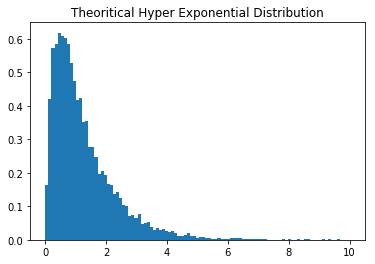

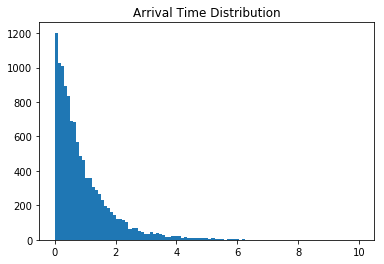

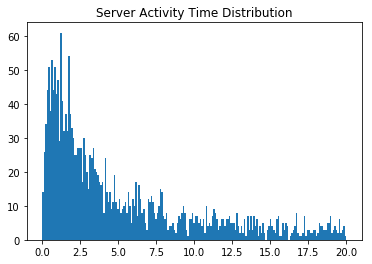

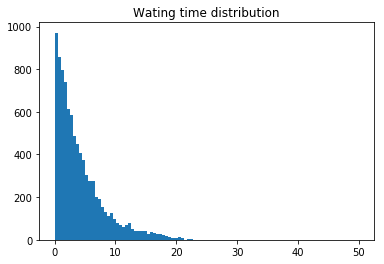

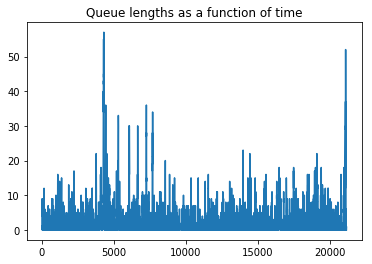

In [198]:
plt.figure()
plt.hist(probs,bins=np.linspace(0,10,100),normed=True)
plt.title('Theoritical Hyper Exponential Distribution')
plt.figure()
plt.hist(At,bins=np.linspace(0,10,100))
plt.title('Arrival Time Distribution')
plt.figure()
plt.hist(SAt,bins=np.linspace(0,20,200))
plt.title('Server Activity Time Distribution')
Ql = np.array(Ql)
plt.figure()
plt.title('Wating time distribution')
plt.hist(Qt,bins=np.linspace(0,50,100))
plt.figure()
plt.title('Queue lengths as a function of time')
plt.plot(Ql[:,0],Ql[:,1])
plt.show()

In [135]:
Ql,Qt,M,At,SAt,B=SimQueueIPPLimit(1,1,1/8,1/8,1,10000,1,2)

In [202]:
B

1407

In [200]:
Ql,Qt,M,At,SAt,B=SimQueueIPPLimitTime(1,1,1/8,1/8,1,10000,1,20)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [201]:
M

8790

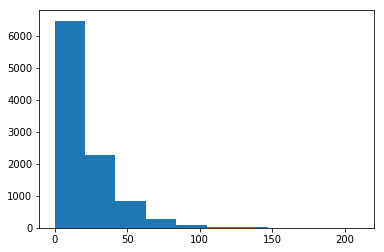

In [172]:
plt.hist(-np.log(np.random.rand(10000))/(1/20))
plt.show()